/scratch/local/50745734/ipykernel_2094531/4050470650.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('SAE_best_model.pth', map_location=device)


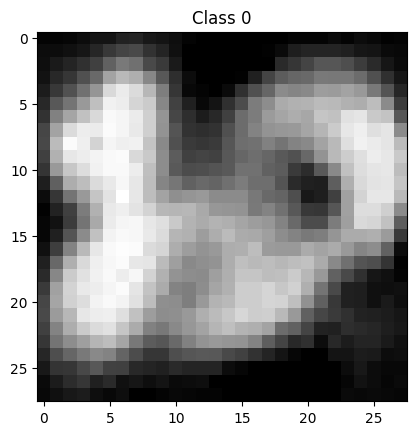

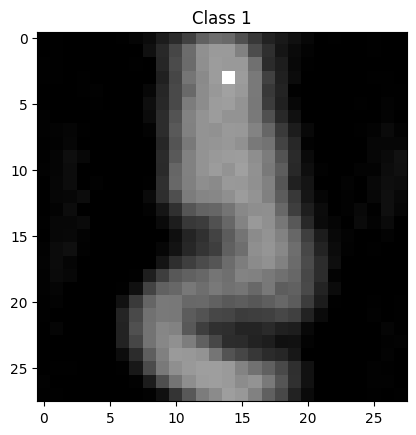

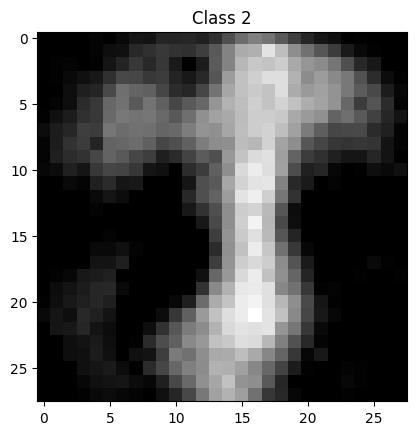

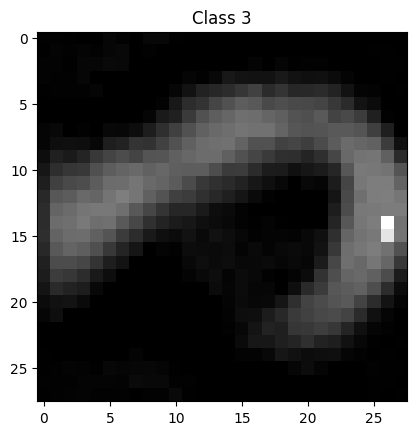

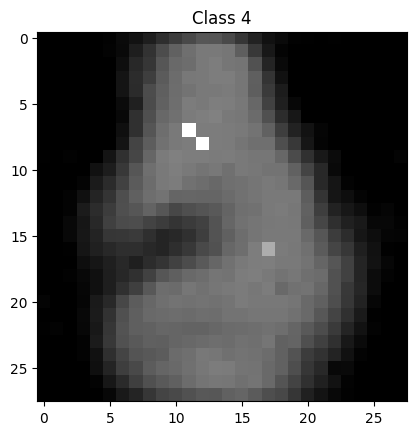

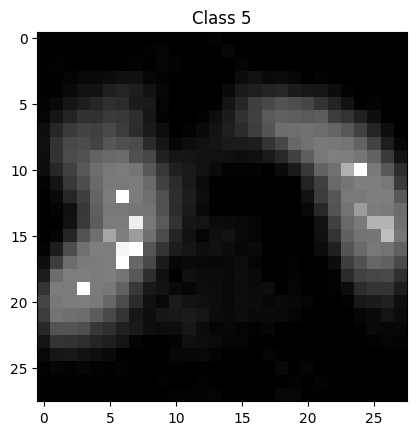

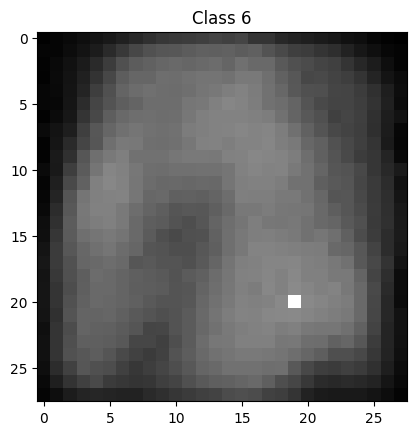

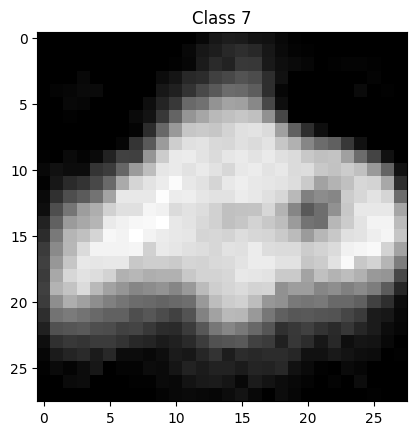

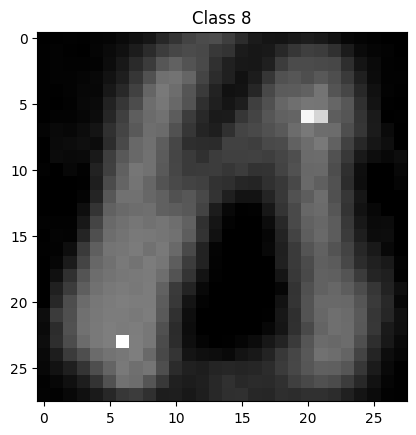

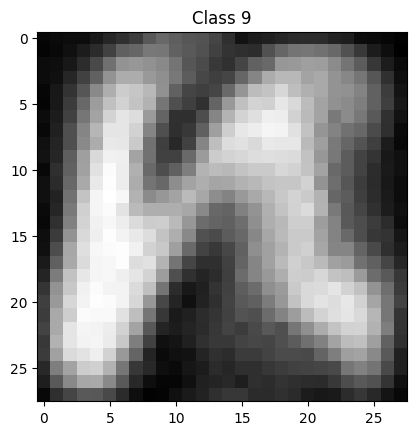

In [1]:
import torch
import numpy as np
import os
from torchvision import datasets, transforms
from SAE_model import StackedAutoencoder  # Import your SAE class
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to a vector
])

# Load the training dataset
train_dataset = datasets.KMNIST(root='../data', train=True, transform=transform, download=True)

# Load the model checkpoint
checkpoint = torch.load('SAE_best_model.pth', map_location=device)

# Reconstruct the model
config = checkpoint['config']
hyperparameters = checkpoint['hyperparameters']

# Reconstruct activation functions
leaky_relu_negative_slope = hyperparameters['leaky_relu_negative_slope']
layer_sizes = config['layer_sizes']
activation_functions = [nn.LeakyReLU(negative_slope=leaky_relu_negative_slope) for _ in layer_sizes]

# Reconstruct the model
model = StackedAutoencoder(
    input_size=config['input_size'],
    layer_sizes=config['layer_sizes'],
    activation_functions=activation_functions,
    dropout_rates=config['dropout_rates']
).to(device)

model.load_state_dict(checkpoint['state_dict'])

# Freeze the weights
for param in model.parameters():
    param.requires_grad = False

# Set the model to evaluation mode
model.eval()

# Define encode and decode functions
def encode(model, x):
    # Use the get_encoded_features method or model.encoder(x)
    return model.get_encoded_features(x)

def decode(model, z):
    return model.decoder(z)

# Obtain one code for each of the classes
from torch.utils.data import DataLoader

class_codes = {}
classes_found = set()
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

for data in train_loader:
    inputs, labels = data
    label = labels.item()
    if label not in classes_found:
        inputs = inputs.to(device)
        code = encode(model, inputs)
        class_codes[label] = code
        classes_found.add(label)
    if len(classes_found) == 10:
        break

# Generate 1,000 images by adding noise to codes
num_images_per_class = 100
os.makedirs('generated_images', exist_ok=True)

for label in range(10):  # For each class
    code = class_codes[label]
    code_dim = code.shape  # Should be (1, code_size)
    code = code.to(device)
    variances = np.linspace(0.01, 0.5, num_images_per_class)
    for i in range(num_images_per_class):
        variance = variances[i]
        noise = torch.randn(code_dim).to(device) * variance
        noisy_code = code + noise
        # Decode to generate image
        generated_image = decode(model, noisy_code)
        # Denormalize and reshape
        generated_image = generated_image.cpu().view(28, 28)
        generated_image = generated_image * 0.5 + 0.5  # Denormalize to [0,1]
        # Clamp values to [0,1]
        generated_image = torch.clamp(generated_image, 0, 1)
        # Convert to numpy array
        generated_image_np = generated_image.numpy()
        # Convert to PIL Image
        generated_image_pil = Image.fromarray(np.uint8(generated_image_np * 255), mode='L')
        # Save image
        filename = f'generated_images/class_{label}_image_{i}.png'
        generated_image_pil.save(filename)

# Optional: display some images
# For example, display one image per class
for label in range(10):
    filename = f'generated_images/class_{label}_image_0.png'
    image = Image.open(filename)
    plt.imshow(image, cmap='gray')
    plt.title(f'Class {label}')
    plt.show()
